# Exploração ML do readcounts 
É um dataset com a abundancia taxonomica

In [35]:
import numpy as np
import pandas as pd

readcounts_train = pd.read_csv("train/readcounts_training.csv")
readcounts_test = pd.read_csv("test/readcounts_test.csv")
pheno_train = pd.read_csv("train/pheno_training.csv")
pheno_test = pd.read_csv("test/pheno_test.csv")


#### Pré-processamento de dados

In [3]:
# get indexes of the rows without nan values
inds_train = pheno_train.dropna().index
inds_test = pheno_test.dropna().index

# data structure organization - train
pheno_train_y = pheno_train.PrevalentHFAIL[inds_train]
readcounts_train_X = readcounts_train.iloc[:, 1:].T # tranpose dataset for compablility
readcounts_train_X.columns = list(readcounts_train["Unnamed: 0"]) # renaming columns for acessibility
readcounts_train_X = readcounts_train_X.iloc[inds_train] # using only rows without nan

# data structure organization - test
pheno_test_y = pheno_test.PrevalentHFAIL[inds_test]
readcounts_test_X = readcounts_test.iloc[:, 1:].T # tranpose dataset for compablility
readcounts_test_X.columns = list(readcounts_test["Unnamed: 0"]) # renaming columns for acessibility
readcounts_test_X = readcounts_test_X.iloc[inds_test] # using only rows without nan

## Feature selection
#### PCA

In [13]:
from sklearn.decomposition import PCA
pca_train = PCA(n_components=0.8)
pca_train.fit(readcounts_train_X)
train_X_reduced = pca_train.transform(readcounts_train_X)
train_X_reduced.shape[1]

8

Var. explained: [0.43877504 0.11459937 0.09547422 0.05715599 0.03265134 0.02669431
 0.02054049 0.01900806]


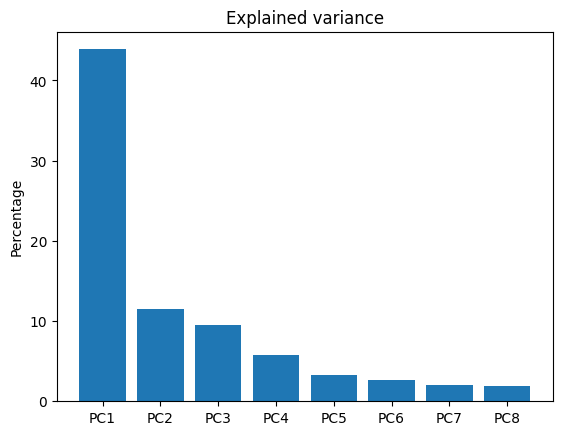

In [15]:
import matplotlib.pyplot as plt
print('Var. explained: %s'% str(pca_train.explained_variance_ratio_))
n_pc = 8
plt.bar(range(n_pc), pca_train.explained_variance_ratio_[0:10]*100)
plt.xticks(range(n_pc), ['PC'+str(i) for i in range(1,n_pc+1)])
plt.title("Explained variance")
plt.ylabel("Percentage")
plt.show()

3564


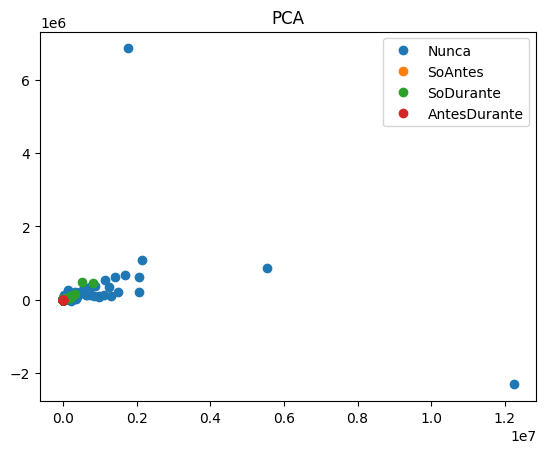

In [49]:
# Falta o grafico
# Criar um lista com a classificação de HF
"""
Nunca tiveram: PrevalentHFAIL == 0 and Event == 0
Só tiveram previamente: PrevalentHFAIL == 1 and Event == 0
Só tiveram durante: PrevalentHFAIL == 0 and Event == 1
Tiveram antes e durante: PrevalentHFAIL == 1 and Event == 1
"""
pheno_train.dropna()
tipo_HF = []
for i in range(pheno_train.shape[0]):
    if pheno_train.loc[i]["PrevalentHFAIL"] == 0 and pheno_train.loc[i]["Event"] == 0:
        tipo_HF.append("Nunca")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 1 and pheno_train.loc[i]["Event"] == 0:
        tipo_HF.append("SoAntes")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 0 and pheno_train.loc[i]["Event"] == 1:
        tipo_HF.append("SoDurante")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 1 and pheno_train.loc[i]["Event"] == 1:
        tipo_HF.append("AntesDurante")

print(len(tipo_HF))
HF_Nunca = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "Nunca"]
HF_SoAntes = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "SoAntes"]
HF_SoDurante = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "SoDurante"]
HF_AntesDurante = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "AntesDurante"]


# Grafico
plt.plot(train_X_reduced[HF_Nunca,0],train_X_reduced[HF_Nunca,1],'o',label="Nunca")
plt.plot(train_X_reduced[HF_SoAntes,0],train_X_reduced[HF_SoAntes,1],'o',label="SoAntes")
plt.plot(train_X_reduced[HF_SoDurante,0],train_X_reduced[HF_SoDurante,1],'o',label="SoDurante")
plt.plot(train_X_reduced[HF_AntesDurante,0],train_X_reduced[HF_AntesDurante,1],'o',label="AntesDurante")
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show()


In [50]:
from sklearn.cluster import KMeans

k=6
kmeans_har = KMeans(n_clusters=k, max_iter=1000)
kmeans_har.fit(readcounts_train_X)
labels = kmeans_har.labels_

pd.crosstab(labels, tipo_HF, rownames=['clusters'] )

ValueError: All arrays must be of the same length

## Medelos de ML
#### Logistic Regression

In [6]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(readcounts_train_X, pheno_train_y)
logistic_prev = logistic.predict(readcounts_test_X)

print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

#### Linear Regression

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

regr_model = linear_model.LinearRegression()
regr_model = regr_model.fit(readcounts_train_X, pheno_train_y)
regr_model_pred = regr_model.predict(readcounts_test_X)

print(regr_model_pred)

print("Perc. acertos: ", (regr_model_pred == pheno_test_y).sum()/len(regr_model_pred))

[ 0.86122398 -0.38107011  1.32693569 ...  1.2188943   0.01503669
  0.27478267]
Perc. acertos:  0.0


#### SVM's

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVM = svm.SVC(gamma=0.001, C=100.)
SVM = SVM.fit(readcounts_train_X, pheno_train_y)
svm_pred = SVM.predict(readcounts_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, svm_pred))

PECC (accuracy): 0.9784580498866213


#### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(readcounts_train_X, pheno_train_y)
knn_pred = knn.predict(readcounts_test_X)
print("Perc. acertos: ", (knn_pred == pheno_test_y).sum()/len(knn_pred))

Perc. acertos:  0.9784580498866213


#### Decision Tree

In [ ]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(readcounts_train_X, pheno_train_y)
preds_tree = tree_model.predict(readcounts_test_X)

print("Perc. acertos: ", (preds_tree == pheno_test_y).sum()/len(preds_tree))

Perc. acertos:  0.9438775510204082


### Ensembles
#### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
DTree = tree.DecisionTreeClassifier(max_depth=4)
knn_class = KNeighborsClassifier(n_neighbors=7)
svc = svm.SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', DTree), ('knn', knn_class), ('svc', svc)], voting='hard')

eclf = eclf.fit(readcounts_train_X, pheno_train_y)
print(eclf.score(readcounts_test_X, pheno_test_y))

0.9784580498866213
